## Test torch functions

In [2]:
# check current working env
import os
print(os.environ['CONDA_DEFAULT_ENV'])

mysoden


In [1]:
import pandas as pd
import numpy as np
import torch

In [4]:
y = torch.tensor([1, 2, 3, 4, 5, 6])
y

tensor([1, 2, 3, 4, 5, 6])

In [16]:
# view: Returns a new tensor with the same data as the self tensor but of a different shape.
Lambda_t = y.index_select(-1, torch.tensor([0])).view(-1, 1) ## retrieve Lambda_t from y, returns as a 2-D tensor of 1 element
Lambda_t

tensor([[1]])

In [17]:
T = y.index_select(-1, torch.tensor([1])).view(-1, 1)  ## retrieve the final time step T from y, returns as a 2-D tensor of 1 element
T

tensor([[2]])

In [18]:
x = y.index_select(-1, torch.tensor(range(2, y.size(-1))))
x

tensor([3, 4, 5, 6])

In [19]:
torch.tensor(x, dtype=torch.long)

/var/folders/c9/0gy2v_0d78n1jtsyrj6hc4qm0000gn/T/ipykernel_39378/3381573197.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x, dtype=torch.long)


tensor([3, 4, 5, 6])

In [21]:
x.to(torch.long)

tensor([3, 4, 5, 6])

In [43]:
import torch.nn as nn
feature_size = 4

In [44]:
embed = nn.Embedding(1602, feature_size)
embed(x.to(torch.long))

tensor([[-0.4078, -0.7414, -1.5151, -0.7076],
        [-0.2540,  0.5423, -0.4350,  1.1568],
        [-0.7054, -0.3997,  0.3515, -0.0304],
        [ 2.1536,  0.7084, -0.3678, -1.0363]], grad_fn=<EmbeddingBackward0>)

In [45]:
t = torch.tensor(5)
t

tensor(5)

In [47]:
# concatenate Lambda_t, t*T, and x into a 1-D tensor
inp = torch.cat(
            [Lambda_t,
             t.repeat(T.size()) * T,  # s = t * T
             x.view(-1, feature_size)], dim=1)
inp

tensor([[ 1, 10,  3,  4,  5,  6]])

In [55]:
inp.size()

torch.Size([1, 6])

In [49]:
T.size()

torch.Size([1, 1])

In [50]:
t.repeat(T.size()) # Repeats the tensor t along the specified dimensions.

tensor([[5]])

In [51]:
t.repeat(T.size()) * T

tensor([[10]])

In [52]:
T

tensor([[2]])

In [53]:
x

tensor([3, 4, 5, 6])

In [54]:
## make a complete nn model with specified layers and sizes
def make_net(input_size, hidden_size, num_layers, output_size, dropout=0,
             batch_norm=False, act="relu", softplus=True):
    if act == "selu":
        ActFn = nn.SELU
    else:
        ActFn = nn.ReLU
    modules = [nn.Linear(input_size, hidden_size), ActFn()]   ## Applies a linear transformation to the incoming data
    if batch_norm:
        modules.append(nn.BatchNorm1d(hidden_size))
    if dropout > 0:
        modules.append(nn.Dropout(p=dropout))
    if num_layers > 1:
        for _ in range(num_layers - 1):
            modules.append(nn.Linear(hidden_size, hidden_size))
            modules.append(ActFn())
            if batch_norm:
                modules.append(nn.BatchNorm1d(hidden_size))
            if dropout > 0:
                modules.append(nn.Dropout(p=dropout))
    modules.append(nn.Linear(hidden_size, output_size))
    if softplus:  # ODE models
        modules.append(nn.Softplus())
    return nn.Sequential(*modules)

In [57]:
net = make_net(6, 3, num_layers = 2, output_size = 1, dropout=0,
             batch_norm=False, act="relu", softplus=True)

In [67]:
# solve dtype error
inp.dtype
inp = inp.to(torch.float32)

In [64]:
net(inp)

tensor([[0.4979]], grad_fn=<SoftplusBackward0>)

In [66]:
output = net(inp) * T
output

tensor([[0.9958]], grad_fn=<MulBackward0>)

In [68]:
x.view(-1, 1)

tensor([[3],
        [4],
        [5],
        [6]])

## Test foward function in NonCoxFuncModel

In [75]:
# define a sample input
inputs = {
  "t": torch.tensor(5),
  "init_cond": torch.tensor(1),
  "features": torch.tensor([[3, 4, 5, 6]])
}

In [77]:
# retrieve information from input
t = inputs["t"]
print("t: ", t)
init_cond = inputs["init_cond"]
print("init_cond: ", init_cond)
features = inputs["features"]
print("features: ", features)
init_cond = torch.cat([init_cond.view(-1, 1), t.view(-1, 1), features], dim=1)  ## rearrange; equiv to c(init_cond, t, features)
t = torch.tensor([0., 1.])
print("new t: ", t)

t:  tensor(5)
init_cond:  tensor(1)
features:  tensor([[3, 4, 5, 6]])
new t:  tensor([0., 1.])


In [73]:
init_cond.view(-1, 1)

tensor([[1]])

In [74]:
t.view(-1, 1)

tensor([[5]])

In [78]:
init_cond

tensor([[1, 5, 3, 4, 5, 6]])

In [79]:
class BaseSurvODEFunc(nn.Module):
    def __init__(self):
        super(BaseSurvODEFunc, self).__init__()
        self.nfe = 0
        self.batch_time_mode = False

    def set_batch_time_mode(self, mode=True):
        self.batch_time_mode = mode
        # `odeint` requires the output of `odefunc` to have the same size as
        # `init_cond` despite the how many steps we are going to evaluate. Set
        # `self.batch_time_mode` to `False` before calling `odeint`. However,
        # when we want to call the forward function of `odefunc` directly and
        # when we would like to evaluate multiple time steps at the same time,
        # set `self.batch_time_mode` to `True` and the output will have size
        # (len(t), size(y)).

    ## What is nfe??
    def reset_nfe(self):
        self.nfe = 0

    def forward(self, t, y):
        raise NotImplementedError("Not implemented.")

In [80]:
class ContextRecMLPODEFunc(BaseSurvODEFunc):
    def __init__(self, feature_size, hidden_size, num_layers, batch_norm=False,
                 use_embed=True):
        super(ContextRecMLPODEFunc, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_norm = batch_norm
        self.use_embed = use_embed
        if use_embed:
            self.embed = nn.Embedding(1602, self.feature_size)  ## A simple lookup table that maps index value to a weighted matrix of certain dimension
        else:
            self.embed = None
        self.net = make_net(input_size=feature_size+2, hidden_size=hidden_size,
                            num_layers=num_layers, output_size=1,
                            batch_norm=batch_norm)
    
    ## ---where does the y come from?--- passed within odeint as init_cond?
    ## forward propagetion; one step forward
    ## outputs a number from nn
    def forward(self, t, y):
        """
        Arguments:
          t: When self.batch_time_mode is False, t is a scalar indicating the
            time step to be evaluated. When self.batch_time_mode is True, t is
            a 1-D tensor with a single element [1.0].
          y: When self.batch_time_mode is False, y is a 1-D tensor with length
            2 + k, where the first dim indicates Lambda_t, the second dim
            indicates the final time step T to be evaluated, and the remaining
            k dims indicates the features. When self.batch_time_mode is True, y
            is a 2-D tensor with batch_size * (2 + k).
        """
        self.nfe += 1
        device = next(self.parameters()).device
        Lambda_t = y.index_select(-1, torch.tensor([0]).to(device)).view(-1, 1) ## retrieve Lambda_t from y, returns as a 2-D tensor of 1 element
        T = y.index_select(-1, torch.tensor([1]).to(device)).view(-1, 1)  ## retrieve the final time step T from y, returns as a 2-D tensor of 1 element
        x = y.index_select(-1, torch.tensor(range(2, y.size(-1))).to(device))  ## retrieve features from y, returns as a 1-D tensor
        if self.use_embed:
            x = torch.mean(
                self.embed(torch.tensor(x, dtype=torch.long).to(device)),
                dim=1)
        # Rescaling trick  ## time rescaling
        # $\int_0^T f(s; x) ds = \int_0^1 T f(tT; x) dt$, where $t = s / T$
        inp = torch.cat(
            [Lambda_t,
             t.repeat(T.size()) * T,  # s = t * T; time step to be evaluated * final time step
             x.view(-1, self.feature_size)], dim=1)
        output = self.net(inp) * T  # f(tT; x) * T
        zeros = torch.zeros_like(
            y.index_select(-1, torch.tensor(range(1, y.size(-1))).to(device))
        )  ## Returns a tensor filled with the scalar value 0, with the same size as input
        output = torch.cat([output, zeros], dim=1)
        if self.batch_time_mode:
            return output
        else:
            return output.squeeze(0)

In [81]:
# define sample config
config = {
    "hidden_size": 5,
    "num_layers": 2,
    "batch_norm": False
}

In [84]:
# define odefunc
odefunc = ContextRecMLPODEFunc(
                feature_size = 4, hidden_size = config["hidden_size"], num_layers = config["num_layers"],
                batch_norm=config["batch_norm"], use_embed=False)

In [117]:
# initilize output
outputs = {}
# import ode solver
from torchdiffeq import odeint_adjoint as odeint

In [126]:
# change init_cond to floating point Tensor to fix datatype error
init_cond = init_cond.to(torch.float)
# solve ode for Lambda
outputs["Lambda"] = odeint(odefunc, init_cond, t, rtol=1e-4, atol=1e-8)[1:].squeeze()  # size: [length of t] x [batch size] x [dim of y0]  ## Solve ODE for cumulative hazard function
outputs["Lambda"] = outputs["Lambda"].view(1, outputs["Lambda"].size(-1)) ## add to fix dimension error
print(outputs)

{'Lambda': tensor([[4.2693, 5.0000, 3.0000, 4.0000, 5.0000, 6.0000]],
       grad_fn=<ViewBackward0>), 'lambda': tensor([3.2847, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       grad_fn=<SqueezeBackward0>)}


In [127]:
# add outputs
odefunc.set_batch_time_mode(True)
outputs["lambda"] = odefunc(t[1:], outputs["Lambda"]).squeeze()
outputs["lambda"] = outputs["lambda"].view(1, outputs["lambda"].size(-1)) ## add to fix dimension error
outputs["Lambda"] = outputs["Lambda"][:, 0]
outputs["lambda"] = outputs["lambda"][:, 0] / inputs["t"]
print(outputs)

{'Lambda': tensor([4.2693], grad_fn=<SelectBackward0>), 'lambda': tensor([0.6569], grad_fn=<DivBackward0>)}


In [99]:
# debug
t[1:]

tensor([1.])

In [98]:
outputs["Lambda"].dim()

1

In [128]:
outputs["Lambda"][:, 0]

IndexError: too many indices for tensor of dimension 1

In [114]:
# debug dimsion error inside ContextRecMLPODEFunc
# convert y to 2d solves the problem
y = outputs["Lambda"]
y = y.view(1, 6)
print("y:", y)
t_1 = t[1:]
print("t_1:", t_1)

y: tensor([[4.2693, 5.0000, 3.0000, 4.0000, 5.0000, 6.0000]],
       grad_fn=<ViewBackward0>)
t_1: tensor([1.])


In [115]:
Lambda_t = y.index_select(-1, torch.tensor([0])).view(-1, 1) ## retrieve Lambda_t from y, returns as a 2-D tensor of 1 element
T = y.index_select(-1, torch.tensor([1])).view(-1, 1)  ## retrieve the final time step T from y, returns as a 2-D tensor of 1 element
x = y.index_select(-1, torch.tensor(range(2, y.size(-1))))
print("Lambda_t:", Lambda_t)
print("T: ", T)
print("x:", x)

Lambda_t: tensor([[4.2693]], grad_fn=<ViewBackward0>)
T:  tensor([[5.]], grad_fn=<ViewBackward0>)
x: tensor([[3., 4., 5., 6.]], grad_fn=<IndexSelectBackward0>)


In [116]:
feature_size = 4
inp = torch.cat([Lambda_t, t_1.repeat(T.size()) * T,  # s = t * T; time step to be evaluated * final time step
             x.view(-1, feature_size)], dim=1)
print("inp:", inp)
output = net(inp) * T  # f(tT; x) * T
print("output:", output)
zeros = torch.zeros_like(y.index_select(-1, torch.tensor(range(1, y.size(-1)))))  ## Returns a tensor filled with the scalar value 0, with the same size as input
print("zeros:", zeros)
output = torch.cat([output, zeros], dim=1)
print("output:", output)

inp: tensor([[4.2693, 5.0000, 3.0000, 4.0000, 5.0000, 6.0000]],
       grad_fn=<CatBackward0>)
output: tensor([[2.7066]], grad_fn=<MulBackward0>)
zeros: tensor([[0., 0., 0., 0., 0.]])
output: tensor([[2.7066, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<CatBackward0>)


In [109]:
print(t_1.repeat(T.size()) * T)

tensor([[5.]], grad_fn=<MulBackward0>)


In [107]:
T.size()

torch.Size([1, 1])

In [108]:
T

tensor([[5.]], grad_fn=<ViewBackward0>)

In [112]:
y.size(-1)

6

## Test SODENModel

In [129]:
# store NonCoxFuncModel
## The proposed SODEN model
class NonCoxFuncModel(nn.Module):
    """NonCoxFuncModel."""

    def __init__(self, model_config, feature_size=None, use_embed=False):
        """Initializes a NonCoxFuncModel.

        Arguments:
          model_config: An OrderedDict of lists. The keys of the dict indicate
            the names of different parts of the model. Each value of the dict
            is a list indicating the configs of layers in the corresponding
            part. Each element of the list is a list [layer_type, arguments],
            where layer_type is a string and arguments is a dict.
          feature_size: Feature size.
          use_embed: Whether to use embedding layer after input.
        """
        assert feature_size is not None
        super(NonCoxFuncModel, self).__init__()
        self.model_config = model_config
        self.feature_size = feature_size
        config = model_config["ode"]["surv_ode_0"]
        self.func_type = config["func_type"]

        if self.func_type == "rec_mlp":
            self.odefunc = ContextRecMLPODEFunc(
                feature_size, config["hidden_size"], config["num_layers"],
                batch_norm=config["batch_norm"], use_embed=use_embed)     ## initialize ContextRecMLPODEFunc; ode function
        else:
            raise NotImplementedError("Function type %s is not supported."
                                      % self.func_type)

        self.set_last_eval(False)

    def set_last_eval(self, last_eval=True):
        self.last_eval = last_eval

    def forward(self, inputs):
        device = next(self.parameters()).device
        t = inputs["t"]
        init_cond = inputs["init_cond"]
        features = inputs["features"]
        init_cond = torch.cat([init_cond.view(-1, 1), t.view(-1, 1), features],
                              dim=1)  ## rearrange; equiv to c(init_cond, t, features)
        t = torch.tensor([0., 1.]).to(device)

        outputs = {}
        self.odefunc.set_batch_time_mode(False)
        outputs["Lambda"] = odeint(
            self.odefunc, init_cond, t, rtol=1e-4, atol=1e-8)[1:].squeeze()  # size: [length of t] x [batch size] x [dim of y0]  ## Solve ODE for cumulative hazard function
        self.odefunc.set_batch_time_mode(True)
        outputs["lambda"] = self.odefunc(t[1:], outputs["Lambda"]).squeeze()  ## Solve ODE for hazard function
        outputs["Lambda"] = outputs["Lambda"][:, 0]
        outputs["lambda"] = outputs["lambda"][:, 0] / inputs["t"]

        if not self.training:  ## ---where is self.training defined?---
            if self.last_eval and "eval_t" in inputs:
                self.odefunc.set_batch_time_mode(False)
                ones = torch.ones_like(inputs["t"])
                # Eval for time-dependent C-index
                outputs["t"] = inputs["t"]
                outputs["eval_t"] = inputs["eval_t"]
                t = inputs["eval_t"][-1] * ones
                init_cond = inputs["init_cond"]
                features = inputs["features"]
                init_cond = torch.cat(
                    [init_cond.view(-1, 1), t.view(-1, 1), features],
                    dim=1)
                t_max = inputs["eval_t"][-1]
                t = inputs["eval_t"] / t_max
                t = torch.cat([torch.zeros([1]).to(device), t], dim=0)
                outputs["cum_hazard_seqs"] = odeint(
                    self.odefunc, init_cond, t, rtol=1e-4, atol=1e-8)[1:, :, 0]  

                # Eval for Brier Score
                t = inputs["t_max"] * ones
                init_cond = inputs["init_cond"]
                features = inputs["features"]
                init_cond = torch.cat(
                    [init_cond.view(-1, 1), t.view(-1, 1), features],
                    dim=1)
                t_min = inputs["t_min"]
                t_max = inputs["t_max"]
                t = torch.linspace(
                    t_min, t_max, NUM_INT_STEPS, dtype=init_cond.dtype,
                    device=device)
                t = torch.cat([torch.zeros([1]).to(device), t], dim=0)
                t = t / t_max
                outputs["survival_seqs"] = torch.exp(
                    -odeint(self.odefunc, init_cond, t, rtol=1e-4,
                            atol=1e-8)[1:, :, 0])

                for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
                    t = inputs["t_max_{}".format(eps)] * ones
                    init_cond = inputs["init_cond"]
                    features = inputs["features"]
                    init_cond = torch.cat(
                        [init_cond.view(-1, 1), t.view(-1, 1), features],
                        dim=1)
                    t_min = inputs["t_min"]
                    t_max = inputs["t_max_{}".format(eps)]
                    t = torch.linspace(
                        t_min, t_max, NUM_INT_STEPS, dtype=init_cond.dtype,
                        device=device)
                    t = torch.cat([torch.zeros([1]).to(device), t], dim=0)
                    t = t / t_max
                    outputs["survival_seqs_{}".format(eps)] = torch.exp(
                        -odeint(self.odefunc, init_cond, t, rtol=1e-4,
                                atol=1e-8)[1:, :, 0])
            
            ## compute Lambda at q25, q50, and q75 
            if "t_q25" in inputs:
                outputs["t"] = inputs["t"]
                self.odefunc.set_batch_time_mode(False)
                for q in ["q25", "q50", "q75"]:
                    t = inputs["t_%s" % q]
                    init_cond = inputs["init_cond"]
                    features = inputs["features"]
                    init_cond = torch.cat(
                        [init_cond.view(-1, 1), t.view(-1, 1), features],
                        dim=1)
                    t = torch.tensor([0., 1.]).to(device)
                    outputs["Lambda_%s" % q] = odeint(
                        self.odefunc, init_cond, t,
                        rtol=1e-4, atol=1e-8)[1:].squeeze()
                    outputs["Lambda_%s" % q] = outputs["Lambda_%s" % q][:, 0]

        return outputs

In [131]:
# define sample model config
model_config = {
    "ode": {
        "surv_ode_0": {
            "layer_type": "surv_ode",
            "func_type": "rec_mlp",
            "hidden_size": 5,
            "num_layers": 2,
            "batch_norm": False
        }
    }
}
print(model_config["ode"]["surv_ode_0"])

{'layer_type': 'surv_ode', 'func_type': 'rec_mlp', 'hidden_size': 5, 'num_layers': 2, 'batch_norm': False}


In [130]:
RNNModel = nn.LSTM
feature_size = {
    "seq_feat": 5,
    "fix_feat": 4
}
seq_feat_size = feature_size["seq_feat"]
rnn = RNNModel(input_size=seq_feat_size,
                                hidden_size=3,
                                num_layers=2,
                                batch_first=True)
feature_size = 3 + feature_size["fix_feat"]

In [132]:
model = NonCoxFuncModel(model_config, 4, False)

In [134]:
model(inputs)

TypeError: `y0` must be a floating point Tensor but is a torch.LongTensor

## Test dataloader

In [136]:
from torch.utils.data import (BatchSampler, DataLoader, Dataset, RandomSampler,
                              SequentialSampler)
from torch.utils.data.dataloader import default_collate

### get_dataloader()

In [138]:
t = np.random.randint(0, 10, size = 10)
print(t)

[7 8 2 8 2 7 2 2 0 7]


In [139]:
N = len(t)
print(N)

10


In [140]:
idx = np.argsort(t)
print(idx)

[8 2 4 6 7 0 5 9 1 3]


In [141]:
t = t[idx]
print(t)

[0 2 2 2 2 7 7 7 8 8]


In [143]:
delta = np.random.randint(0, 2, size = 10)
print(delta)

[0 0 1 0 0 0 1 0 0 0]


In [144]:
delta = delta[idx]
print(delta)

[0 1 0 1 0 0 0 0 0 0]


In [147]:
x = np.random.randint(1, 15, size = (10, 10))
print(x)

[[12  7 11  8 13  8 12  8 11  8]
 [ 6  6  1  9  5  1  2  7 12  4]
 [ 3 11  1  1  7 10  8 10 13  5]
 [ 8  7  5  9 12 12 12  9  4  1]
 [ 7  9  8 12 11  6 12 13  6  9]
 [ 9  6 14 14 12  1  5 14  1  4]
 [12 11 13  2 12 11 14  1 10 13]
 [10 11  2 12  8  5 11 12 12  4]
 [13  7  4  3  9  3  4  7  4  7]
 [ 1  7  8  8  7  6  2 13  6  3]]


In [145]:
init_cond = np.zeros_like(t)
print(init_cond)

[0 0 0 0 0 0 0 0 0 0]


In [146]:
labels = torch.tensor(delta, dtype=torch.float)
print(labels)

tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])


In [148]:
features = {}
features["t"] = torch.tensor(t, dtype=torch.float)
features["init_cond"] = torch.tensor(init_cond, dtype=torch.float)
features["features"] = torch.tensor(x, dtype=torch.float)
features["index"] = torch.arange(N, dtype=torch.long)
print(features)

{'t': tensor([0., 2., 2., 2., 2., 7., 7., 7., 8., 8.]), 'init_cond': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'features': tensor([[12.,  7., 11.,  8., 13.,  8., 12.,  8., 11.,  8.],
        [ 6.,  6.,  1.,  9.,  5.,  1.,  2.,  7., 12.,  4.],
        [ 3., 11.,  1.,  1.,  7., 10.,  8., 10., 13.,  5.],
        [ 8.,  7.,  5.,  9., 12., 12., 12.,  9.,  4.,  1.],
        [ 7.,  9.,  8., 12., 11.,  6., 12., 13.,  6.,  9.],
        [ 9.,  6., 14., 14., 12.,  1.,  5., 14.,  1.,  4.],
        [12., 11., 13.,  2., 12., 11., 14.,  1., 10., 13.],
        [10., 11.,  2., 12.,  8.,  5., 11., 12., 12.,  4.],
        [13.,  7.,  4.,  3.,  9.,  3.,  4.,  7.,  4.,  7.],
        [ 1.,  7.,  8.,  8.,  7.,  6.,  2., 13.,  6.,  3.]]), 'index': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}


In [150]:
# DictDataset.
class DictDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.labels.size(0)

    def __getitem__(self, idx):
        sample_features = {}
        for key in self.features:
            sample_features[key] = self.features[key][idx]
        return sample_features, self.labels[idx]

In [151]:
dataset = DictDataset(features, labels)
print(dataset)

In [152]:
# Batch random sampler that maintains order within each batch.
class OrderedBatchRandomSampler(object):
    def __init__(self, n, batch_size, seed=13, drop_last=False):
        super(OrderedBatchRandomSampler, self).__init__()
        self.n = n
        self.batch_size = batch_size
        self.seed = seed
        self.drop_last = drop_last
        self.random_state = np.random.RandomState(seed)

    def __len__(self):
        if self.drop_last:
            return self.n // self.batch_size
        else:
            return (self.n + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        batch = []
        for idx in self.random_state.permutation(self.n):  ## generate random indices
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield sorted(batch)
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield sorted(batch)  ## Return sends a specified value back to its caller whereas Yield can produce a sequence of values. 

In [162]:
sampler = OrderedBatchRandomSampler(N, batch_size = 2, drop_last=True)

In [163]:
_collate_fn = default_collate

In [164]:
NUM_WORKERS = 0
dataloader = DataLoader(
        dataset, batch_sampler=sampler, collate_fn=_collate_fn, pin_memory=True,
        num_workers=NUM_WORKERS)
print(dataloader)

In [165]:
for batch_data in dataloader:
    print(batch_data)

[{'t': tensor([2., 7.]), 'init_cond': tensor([0., 0.]), 'features': tensor([[ 8.,  7.,  5.,  9., 12., 12., 12.,  9.,  4.,  1.],
        [ 9.,  6., 14., 14., 12.,  1.,  5., 14.,  1.,  4.]]), 'index': tensor([3, 5])}, tensor([1., 0.])]
[{'t': tensor([2., 7.]), 'init_cond': tensor([0., 0.]), 'features': tensor([[ 6.,  6.,  1.,  9.,  5.,  1.,  2.,  7., 12.,  4.],
        [12., 11., 13.,  2., 12., 11., 14.,  1., 10., 13.]]), 'index': tensor([1, 6])}, tensor([1., 0.])]
[{'t': tensor([2., 7.]), 'init_cond': tensor([0., 0.]), 'features': tensor([[ 7.,  9.,  8., 12., 11.,  6., 12., 13.,  6.,  9.],
        [10., 11.,  2., 12.,  8.,  5., 11., 12., 12.,  4.]]), 'index': tensor([4, 7])}, tensor([0., 0.])]
[{'t': tensor([8., 8.]), 'init_cond': tensor([0., 0.]), 'features': tensor([[13.,  7.,  4.,  3.,  9.,  3.,  4.,  7.,  4.,  7.],
        [ 1.,  7.,  8.,  8.,  7.,  6.,  2., 13.,  6.,  3.]]), 'index': tensor([8, 9])}, tensor([0., 0.])]
[{'t': tensor([0., 2.]), 'init_cond': tensor([0., 0.]), 'feature

In [169]:
from numpy import load

data = load('data/support/test_1.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])
    print(data[item].shape)

arr_0
[[ 0.5778179  -0.59537214  0.13440911 ... -0.18676585 -1.3885338
   2.489657  ]
 [ 1.1923819  -1.5297642   0.13440911 ... -0.18676585 -1.3885338
   2.489657  ]
 [-0.6891113  -1.0625682   2.0835433  ... -0.18676585 -1.3885338
   2.489657  ]
 ...
 [-0.9417017  -0.05629976 -0.8087203  ... -0.18676585  0.72018415
  -0.40166175]
 [ 1.1944975   0.9499686   0.3859103  ... -0.18676585  0.72018415
  -0.40166175]
 [ 0.83124214  0.8780922   0.3859103  ... -0.18676585 -1.3885338
   2.489657  ]]
(1727, 27)
arr_1
[[4.18891191 0.        ]
 [0.05201916 1.        ]
 [0.75017112 1.        ]
 ...
 [1.66461325 0.        ]
 [0.09856263 1.        ]
 [0.02737851 1.        ]]
(1727, 2)
arr_2
[[ 71.45795  68.      102.      ...   0.        0.        1.     ]
 [ 81.03198  42.      102.      ...   0.        0.        1.     ]
 [ 51.72098  55.      164.      ...   0.        0.        1.     ]
 ...
 [ 47.78598  83.       72.      ...   0.        1.        0.     ]
 [ 81.06494 111.      110.      ...   0.    

## Test survival_seq

In [4]:
t = torch.linspace(1, 10, 20, dtype=torch.float32, device="cpu")

In [5]:
t

tensor([ 1.0000,  1.4737,  1.9474,  2.4211,  2.8947,  3.3684,  3.8421,  4.3158,
         4.7895,  5.2632,  5.7368,  6.2105,  6.6842,  7.1579,  7.6316,  8.1053,
         8.5789,  9.0526,  9.5263, 10.0000])

## Test using model

In [3]:
torch.cuda.is_available()

True

In [65]:
model = torch.load("data/metabric/models/best_ckpt__ode__metabric__rec_mlp__0__split_1__seed_1.pt")
outputs = model["model_output"]
eval_t = outputs["eval_t"]
survival_seqs = outputs["survival_seqs"]
cum_hazard_seqs = outputs["cum_hazard_seqs"]
cum_hazard_seqs.shape

torch.Size([405, 411])

In [66]:
eval_t = eval_t.cpu().detach().numpy()
eval_t.shape

(405,)

In [67]:
last_cum_hazard_seq = cum_hazard_seqs[:,410]
last_cum_hazard_seq = last_cum_hazard_seq.cpu().detach().numpy()

In [68]:
import matplotlib.pyplot as plt

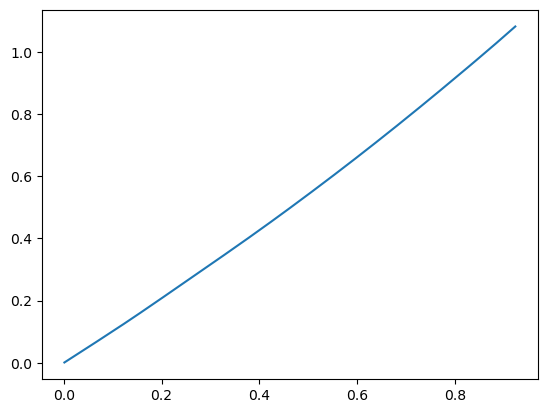

In [69]:
plt.plot(eval_t, last_cum_hazard_seq)

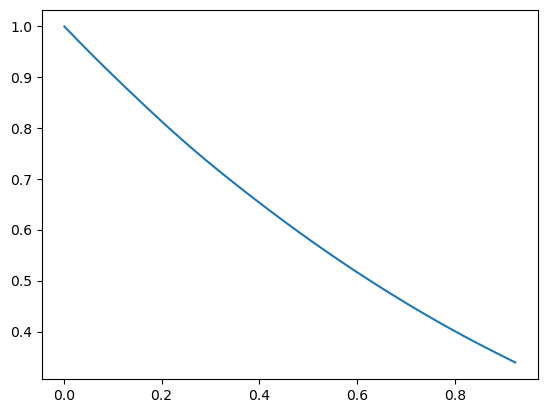

In [70]:
plt.plot(eval_t, np.exp(-last_cum_hazard_seq))

In [29]:
lamda = model["model_output"]["lambda"]
t = model["model_output"]["t"]

In [16]:
t.cpu().detach().numpy()

array([0.98936415, 0.99210197, 0.99483985, 0.99483985, 1.0003155 ,
       1.0003155 , 1.0003155 , 1.0140048 , 1.0140048 , 1.0194806 ,
       1.0249562 , 1.0249562 , 1.0276941 , 1.0276941 , 1.0276941 ,
       1.0276941 , 1.030432  , 1.0386455 , 1.0523348 , 1.0523348 ,
       1.0550725 , 1.0550725 , 1.0550725 , 1.0578104 , 1.0578104 ,
       1.0578104 , 1.0578104 , 1.0605483 , 1.066024  , 1.066024  ,
       1.0687618 , 1.0714997 , 1.0714997 , 1.0742376 , 1.0742376 ,
       1.0769755 , 1.0797132 , 1.085189  , 1.085189  , 1.085189  ,
       1.0879269 , 1.0879269 , 1.0961404 , 1.0988783 , 1.101616  ,
       1.1043539 , 1.1043539 , 1.1098297 , 1.1180432 , 1.1262567 ,
       1.1262567 , 1.1262567 , 1.1262567 , 1.1372081 , 1.1372081 ,
       1.1426839 , 1.1454216 , 1.1454216 , 1.1481595 , 1.1508974 ,
       1.1536353 , 1.156373  , 1.1591109 , 1.1591109 , 1.1618488 ,
       1.1618488 , 1.1673244 , 1.1728002 , 1.1755381 , 1.1755381 ,
       1.1810137 , 1.1919651 , 1.194703  , 1.1974409 , 1.19744

In [23]:
Lambda = model["model_output"]["Lambda"].cpu().detach().numpy()
survival = np.exp(-Lambda)

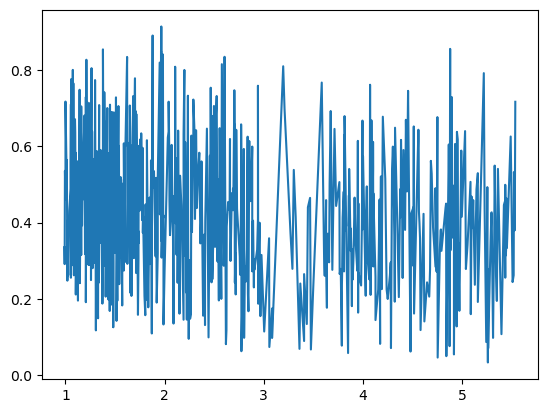

In [21]:
plt.plot(t.cpu().detach().numpy(), survival)

In [26]:
import pickle

with open('data/support/results/eval/0.691119__ode__support__rec_mlp__0__split_1__seed_1__fine_tune.pkl', 'rb') as f:
    data = pickle.load(f)

In [27]:
data

{'valid': [{'survival_loss': [0.6911187879741192],
   'concordance_q25': [0.5999062321057148],
   'concordance_q50': [0.6075129133257867],
   'concordance_q75': [0.5953790239601259],
   'concordance_time_dependent': [0.6188078728722091],
   'ipw_concordance_time_dependent': [0.6187702881244055],
   'ipw_2_concordance_time_dependent': [0.6195214111707574],
   'ipw_4_concordance_time_dependent': [0.619298822641952],
   'brier_score': 0.19573993529191763,
   'brier_score_2': 0.20103019502750333,
   'brier_score_4': 0.20723734030364824,
   'binomial_log_likelihood': -0.5735740219034516,
   'binomial_log_likelihood_2': -0.5860802535669609,
   'binomial_log_likelihood_4': -0.6000823699780904}],
 'test': [{'survival_loss': [0.724410604685545],
   'concordance_q25': [0.5863329344171185],
   'concordance_q50': [0.5933957874749358],
   'concordance_q75': [0.5811462695301159],
   'concordance_time_dependent': [0.6080721219069242],
   'ipw_concordance_time_dependent': [0.612280802991117],
   'ipw_